# Sentiment Analysis for Reviews on Public and Private Services in the Lebanese Context

In [5]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc, classification_report,  roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

## Loading OCLAR - Opinion Corpus for Lebanese Arabic Reviews dataset

In [6]:
df = pd.read_csv('/content/OCLAR - Opinion Corpus for Lebanese Arabic Reviews.csv')

In [7]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
stop_words = set(stopwords.words('arabic'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [9]:
df['review'] = df['review'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.lower().split() if word not in stop_words]))

In [10]:
df['review'] = df['review'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.lower().split() if word not in stop_words]))

<Axes: >

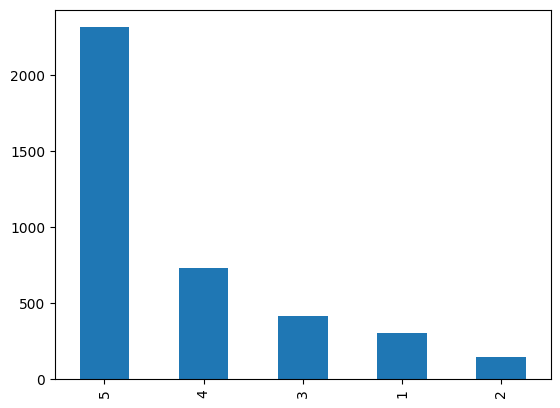

In [11]:
df['rating'].value_counts().plot(kind='bar')

### Data Exploration

### Data Preparation 

In [12]:
df['Sentiment'] = np.where(df['rating'] >= 3, 1, 0)
df.head()

,pagename,review,rating,Sentiment
0,Beirut Golden Plaza Suites,الفندق ينقصه الاشياء داخل الغرف مثلا عدم وضوح ...,2,0
1,Beirut Golden Plaza Suites,لطيف الغرف الفندقية تحتاج صيانة كادر الخدمة يج...,4,1
2,Beirut Golden Plaza Suites,مكان جميل جدا وحسن الخلق والضيافه,5,1
3,Beirut Golden Plaza Suites,بحاجة الى اعادة تأهيل للمفروشات,3,1
4,Beirut Golden Plaza Suites,فندق ممتاز ومعاملة راقية جدا,5,1


<Axes: >

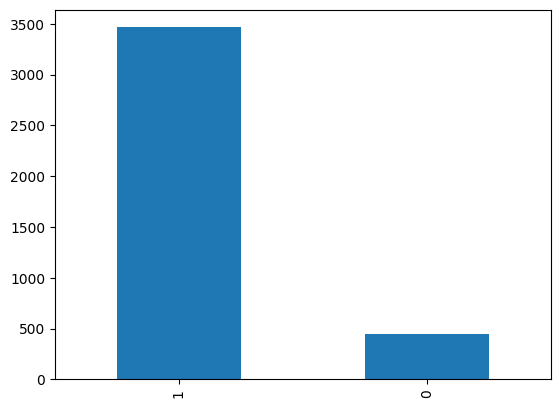

In [13]:
df['Sentiment'].value_counts().plot(kind='bar')

In [14]:
len(df[df.Sentiment==0])

451

In [15]:
len(df[df.Sentiment==1])

3465

### Train Test Split 

In [16]:
# Split data into training set and validation set
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['Sentiment'], test_size=0.2, random_state=0)

In [17]:
print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))

Load 3132 training examples and 784 validation examples. 



In [18]:
len(y_train[y_train==0])

353

In [19]:
len(y_train[y_train==1])

2779

In [20]:
len(y_test[y_test==0])

98

In [21]:
len(y_test[y_test==1])

686

### TfidfVectorizer with Logistic Regression

In [22]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
print("Number of features : %d \n" %len(tfidf.get_feature_names_out()))
print("Show some feature names : \n", tfidf.get_feature_names_out())

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)

Number of features : 6962 

Show some feature names : 
 ['000' '03015081' '10' ... 'ﻻاحب' 'ﻻباس' 'ﻻن']


LogisticRegression()

In [23]:
# Look at the top 10 features with smallest and the largest coefficients
feature_names = np.array(tfidf.get_feature_names_out())
sorted_coef_index = lr.coef_[0].argsort()
print('\nTop 10 features with smallest coefficients :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Top 10 features with largest coefficients : \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))


Top 10 features with smallest coefficients :
['سيئة' 'سيئ' 'سيء' 'عادي' 'بأس' 'ابدا' 'يعجبني' 'صفر' 'مش' 'غالية']

Top 10 features with largest coefficients : 
['ممتاز' 'رائع' 'مطعم' 'مميز' 'لذيذ' 'اطيب' 'طيب' 'رائعة' 'ممتازة' 'جميل']


In [24]:
def modelEvaluation(predictions):
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [25]:
# Evaluate on the validaton set
predictions = lr.predict(tfidf.transform(X_test))
modelEvaluation(predictions)


Accuracy on validation set: 0.8788

AUC score : 0.5197

Classification report : 
               precision    recall  f1-score   support

           0       0.80      0.04      0.08        98
           1       0.88      1.00      0.94       686

    accuracy                           0.88       784
   macro avg       0.84      0.52      0.51       784
weighted avg       0.87      0.88      0.83       784


Confusion Matrix : 
 [[  4  94]
 [  1 685]]


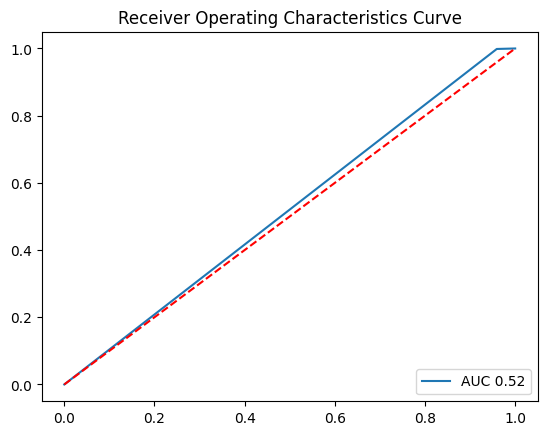

In [26]:
fpr, tpr, _ = roc_curve(y_test,predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='AUC %0.2f'%(roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.title("Receiver Operating Characteristics Curve")
plt.show()